# Reducing Flat images

Written by Evgenii N.

The following code reduces Flat images in `data/flats` and saves reduced images to `data/flats/reduced` directory.

## Prerequisite code

In [1]:
# Import libraries that we will use later in this notebook
import os
import shutil
import ccdproc
import numpy as np
from astropy.visualization import ZScaleInterval, MinMaxInterval, ImageNormalize
from astropy import units as u
from matplotlib.colors import LogNorm
from ccdproc import CCDData
import matplotlib.pyplot as plt

# Make images non-blurry on high pixel density screens
%config InlineBackend.figure_format = 'retina'

# Title size
plt.rcParams['axes.titlesize'] = 16

# Axes label size
plt.rcParams['axes.labelsize'] = 13


def show_image(image, title):
    """
    Display an image.
    
    Parameters
    ---------
    
    image: astropy.nddata.ccddata.CCDData
        A fits image to show.
        
    title: str
        Plot title.
    """
    fig, ax = plt.subplots(figsize=(12, 8))  # Change image size
    plt.rcParams.update({'font.size': 10})  # Change font size
    
    # Scale the image similar to 'zscale' mode in DS9.
    # This makes easier to spot things in the image.
    interval=ZScaleInterval()
    vmin, vmax = interval.get_limits(image)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    
    plt.imshow(image, cmap='gray', norm=norm)  # Set color map and pixel scaling
    plt.xlabel('x [pixel]')  # Set axis labels
    plt.ylabel('y [pixel]')
    plt.title(title, y=-0.2)  # Set image title
    plt.colorbar()  # Show color bar
    

def print_image_stats(image, title):
    """
    Print first pixel value, average and standard deviation for an image.
    
    Parameters
    ---------
    
    image: astropy.nddata.ccddata.CCDData
        A fits image to show.
        
    title: str
        Image name.
    """
    
    data = np.asarray(image)# Get numpy array for image data
    label_len = 10  # Length of the text label
    first_pixel = data[0, 0]  # First pixel
    average = np.mean(data)  # Average
    standard_deviation = np.std(data)   # Standard deviation


    # Print values
    # -------

    print(
        f'\n{title}',
        f"\n{'-' * len(title)}",
        f"\n{'Pixel:':<10}{first_pixel:>10.2f} ADU",
        f"\n{'Avg:':<10}{average:>10.2f} ADU",
        f"\n{'Std:':<10}{standard_deviation:>10.2f} ADU\n"
    )
    

def save_image(image, file_path):
    """
    Save image to disk
    
    Parameters
    ---------
    image: astropy.nddata.ccddata.CCDData
        Image to be saved
        
    file_path: str
        Path where the image is saved
    """
    
    try:
        os.remove(file_path)
    except OSError:
        pass
    
    # Create directory
    # ------

    dirname = os.path.dirname(file_path)
    
    if not os.path.exists(dirname):
        os.makedirs(dirname)

    image.write(file_path)

## Reducing flats

## Flat files used

* Checking visually with DS9 to make sure there are no stars in the flats. 
* I discarded flat files that contained artifact, like the one shown on Fig. 20.
* Keep flats for B, I, R, V filters. We don't need U-filter images (Vaishali and Michael told us in Week 6 lab).

![Flat with artifacts](images/flat_with_artifacts_Flat_I_4.000secs_00001442.jpg)

Figure 20: Flat file Flat_I_4.000secs_00001442.git from March_09_2018 directory that contains a bright scratch-like artifact. I did not use flat images containing such artifacts.

### Flat files that I ended up using

The following list contains names of flat files that I used, all from March_09_2018.zip archive:

* Flat_B_4.000secs_00001397.fit
* Flat_B_4.000secs_00001398.fit
* Flat_B_4.000secs_00001399.fit
* Flat_B_4.000secs_00001400.fit
* Flat_B_4.000secs_00001401.fit
* Flat_I_4.000secs_00001451.fit
* Flat_I_4.000secs_00001453.fit
* Flat_I_4.000secs_00001454.fit
* Flat_I_4.000secs_00001457.fit
* Flat_I_4.000secs_00001458.fit
* Flat_R_4.000secs_00001427.fit
* Flat_R_4.000secs_00001428.fit
* Flat_R_4.000secs_00001429.fit
* Flat_R_4.000secs_00001430.fit
* Flat_R_4.000secs_00001431.fit
* Flat_V_4.000secs_00001413.fit
* Flat_V_4.000secs_00001414.fit
* Flat_V_4.000secs_00001415.fit
* Flat_V_4.000secs_00001416.fit
* Flat_V_4.000secs_00001417.fit

## Program code

In [2]:
def reduce_flats_for_filter(filter, fits_path, bias, dark, figure_number):
    """
    Reduce the flat files for the given filter
    
    Parameters
    ----------
    
    filter: str
        Name of the filter: 'V', 'B' etc.
        
    fits_path: str
        Directory where flat files are located.
        
    bias: astropy.nddata.ccddata.CCDData
        Reduced bias image.
        
    dark: astropy.nddata.ccddata.CCDData
        Reduced dark image.
        
    figure_number: int
        Figure number for flat image
    """
    
    print(f"\nReducing flats for {filter} filter:")
    
    # Get names of all image files in current directory
    images = ccdproc.ImageFileCollection(fits_path, glob_include = f'Flat_{filter}_*')
    images = images.files_filtered(PICTTYPE = 4)

    for image in images:
        print(image)
        
    # Read the images and store them in a list
    # --------

    flats = [
                CCDData.read(os.path.join(fits_path, fn), unit="adu")
                for fn in images
            ]
    
    print_image_stats(flats[0], title=f"First Flat {filter}")
    print(f"First flat exposure time: {flats[0].header['EXPTIME']} s")

    
    # Subtract median bias from each flat image and store results in a list
    # --------

    flats_bias_subtracted = [
        ccdproc.subtract_bias(image, bias)
        for image in flats
    ]
    
    print_image_stats(flats_bias_subtracted[0], title=f"First Flat, bias subtracted {filter}")
    
    # Subtract dark median image from flats.
    # We also scale by exposure time to make sure
    # the effective exposures of two images are equal.
    # --------

    flats_bias_dark_subtracted = [
        ccdproc.subtract_dark(image, dark, exposure_time='EXPTIME',
                              exposure_unit=u.second, scale=True)
        for image in flats_bias_subtracted
    ]
    
    print_image_stats(flats_bias_dark_subtracted[0],
                      title=f"First Flat, bias and dark subtracted {filter}")
      
    # Scale each flat image, such that median pixel has value of 1
    # -------
        
    flats_scaled = [ 
                        file.multiply(1.0 / np.ma.median(file) * u.adu)
                        for file in flats_bias_dark_subtracted
                   ]

    # Median combine Flats
    flat_median = ccdproc.Combiner(flats_scaled).median_combine()
    
    # Save flat to the file
    flat_median.meta.update(EXPTIME=1)
    flat_median.meta.update(TELESCOP='C11')
    flat_median.meta.update(OBJECT='flat_{filter}_median')
    file_path = os.path.join(fits_path, 'reduced', f'flat_{filter}_median.fits')
    save_image(image=flat_median, file_path=file_path)
    print_image_stats(flat_median, title=f'Combined Flat {filter}')
    show_image(flat_median, title=f'Figure {figure_number}: Reduced {filter} Flat')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

Bias 
---- 
Pixel:        135.00 ADU 
Avg:          109.28 ADU 
Std:            6.78 ADU

Bias exposure time: 0 s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

Dark 
---- 
Pixel:          0.00 ADU 
Avg:           12.46 ADU 
Std:          213.09 ADU

Dark exposure time: 600 s

Reducing flats for B filter:
Flat_B_4.000secs_00001397.fit
Flat_B_4.000secs_00001398.fit
Flat_B_4.000secs_00001399.fit
Flat_B_4.000secs_00001400.fit
Flat_B_4.000secs_00001401.fit

First Flat B 
------------ 
Pixel:       3071.00 ADU 
Avg:         2869.09 ADU 
Std:           47.55 ADU

First flat exposure time: 4.0 s

First Flat, bias subtracted B 
----------------------------- 
Pixel:       2936.00 ADU 
Avg:         2759.81 ADU 
Std:           47.62 ADU


First Flat, bias and dark subtracted B 
-------------------------------

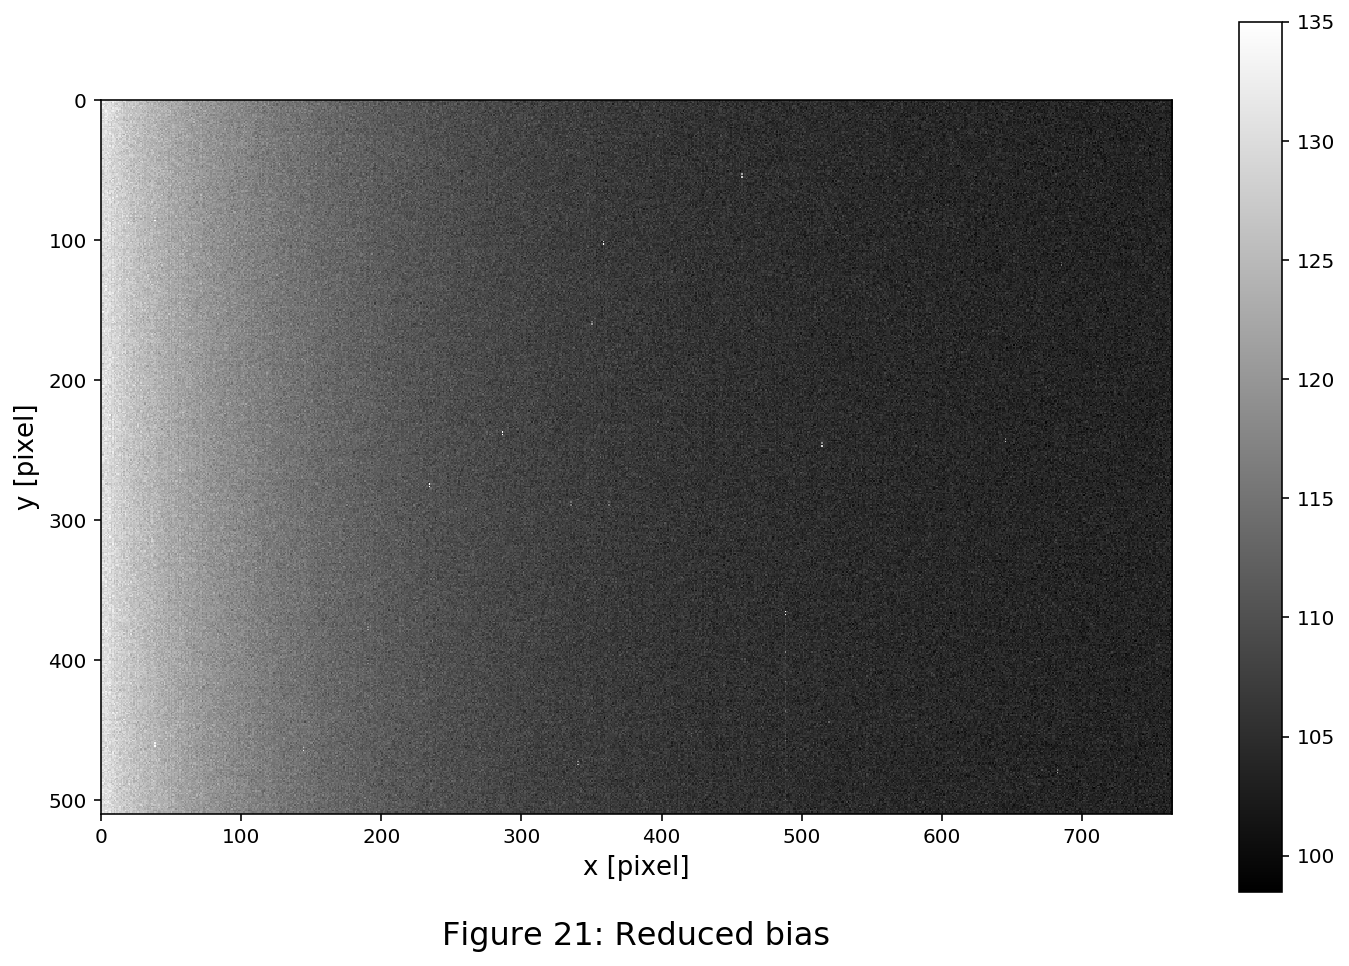

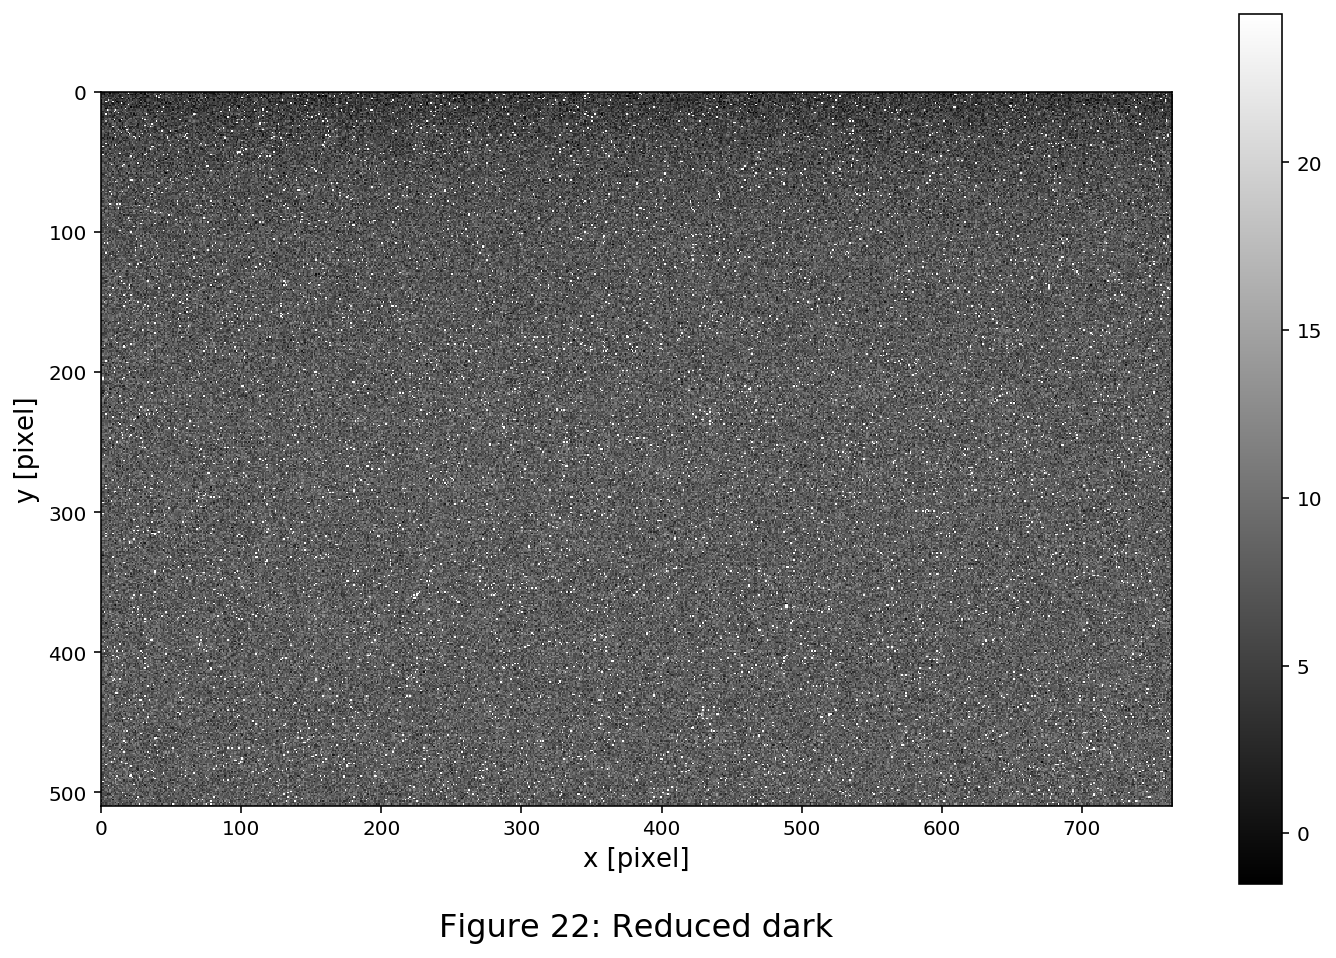

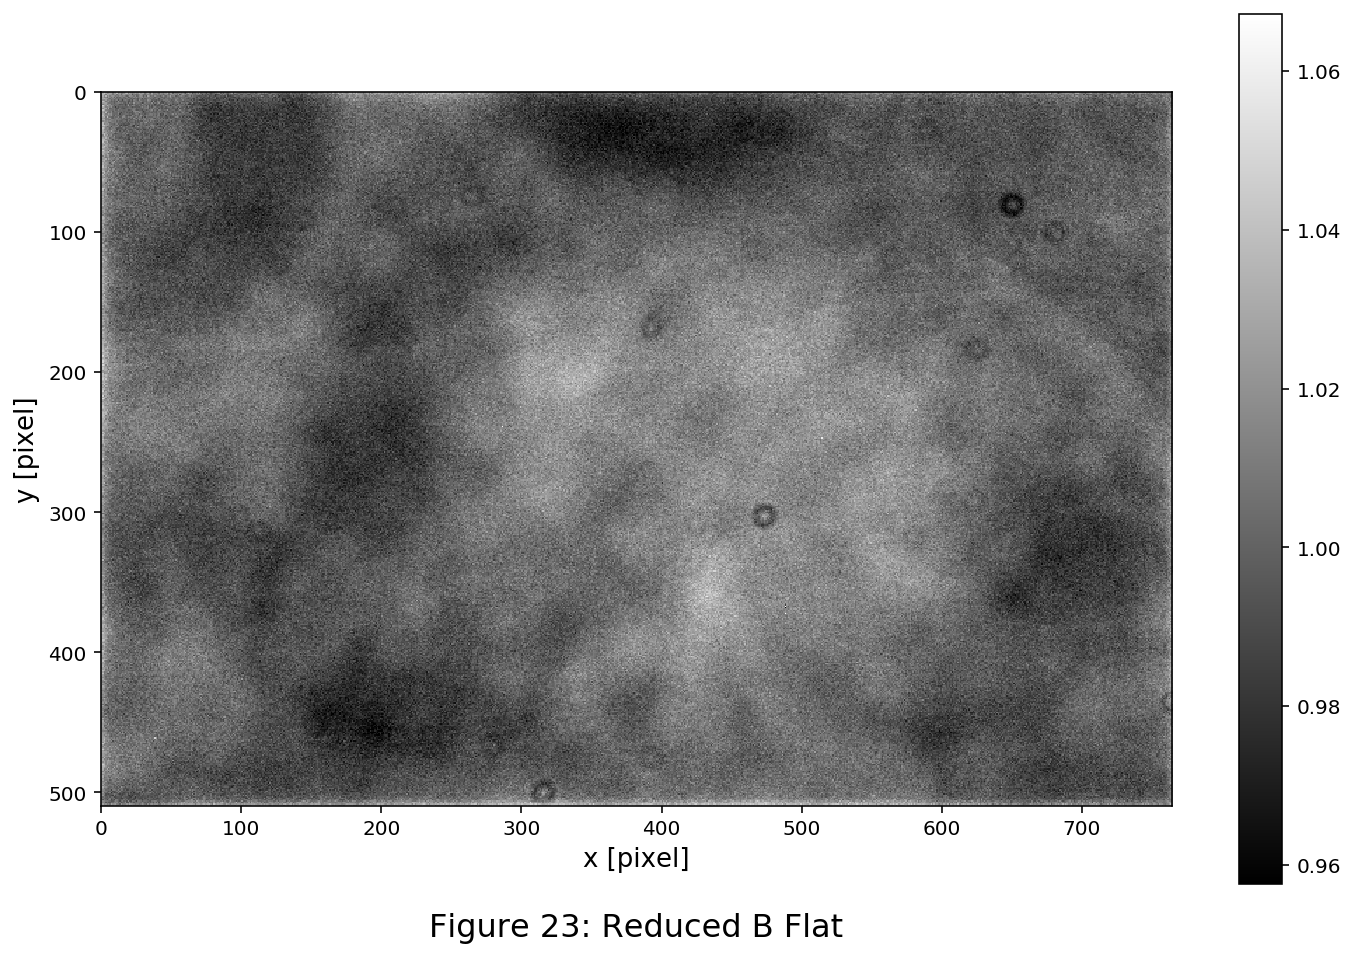

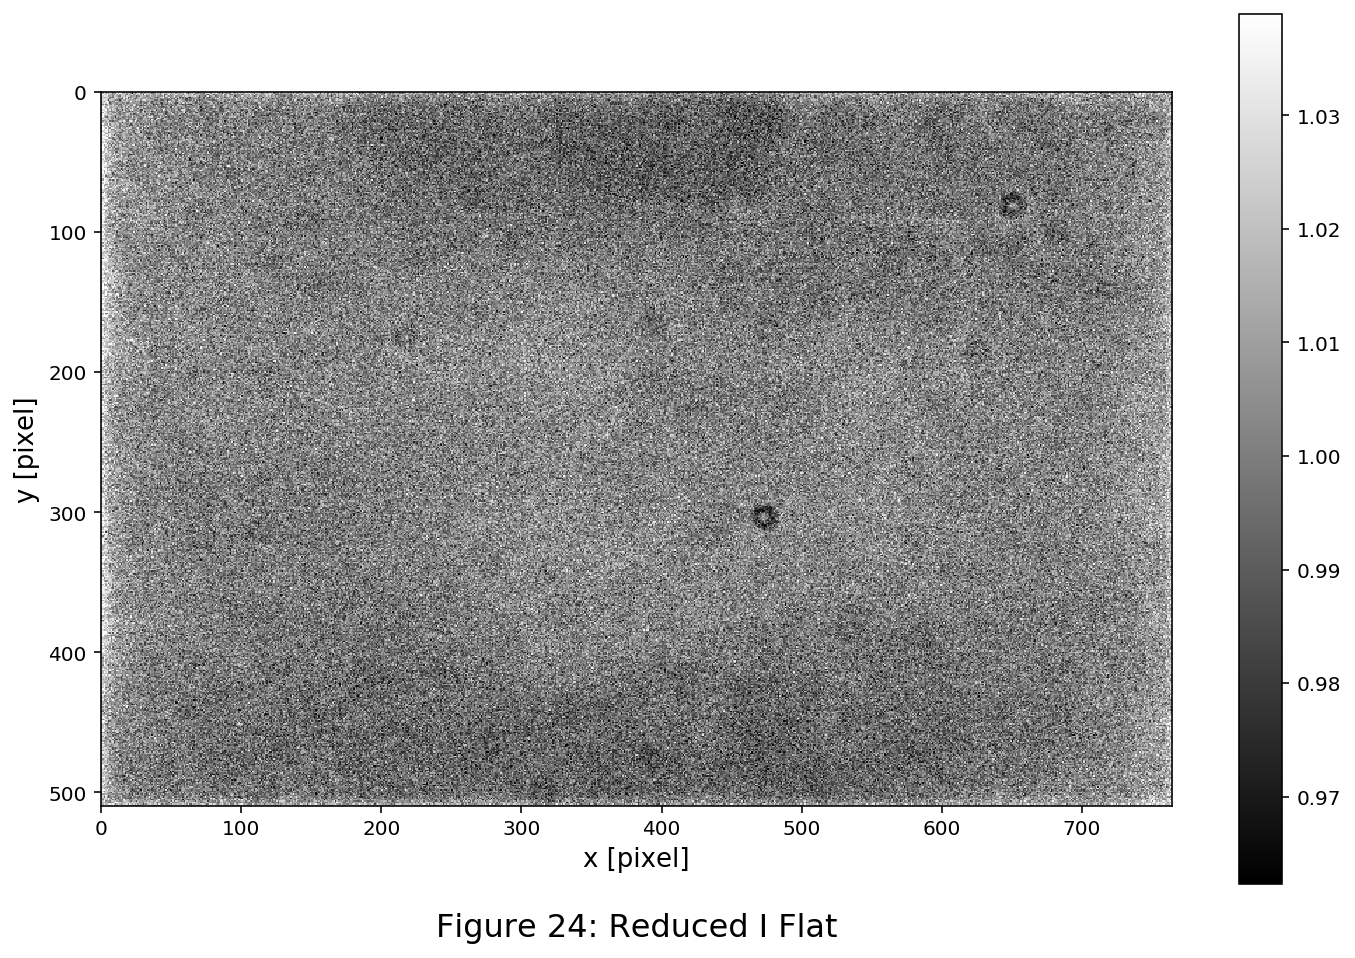

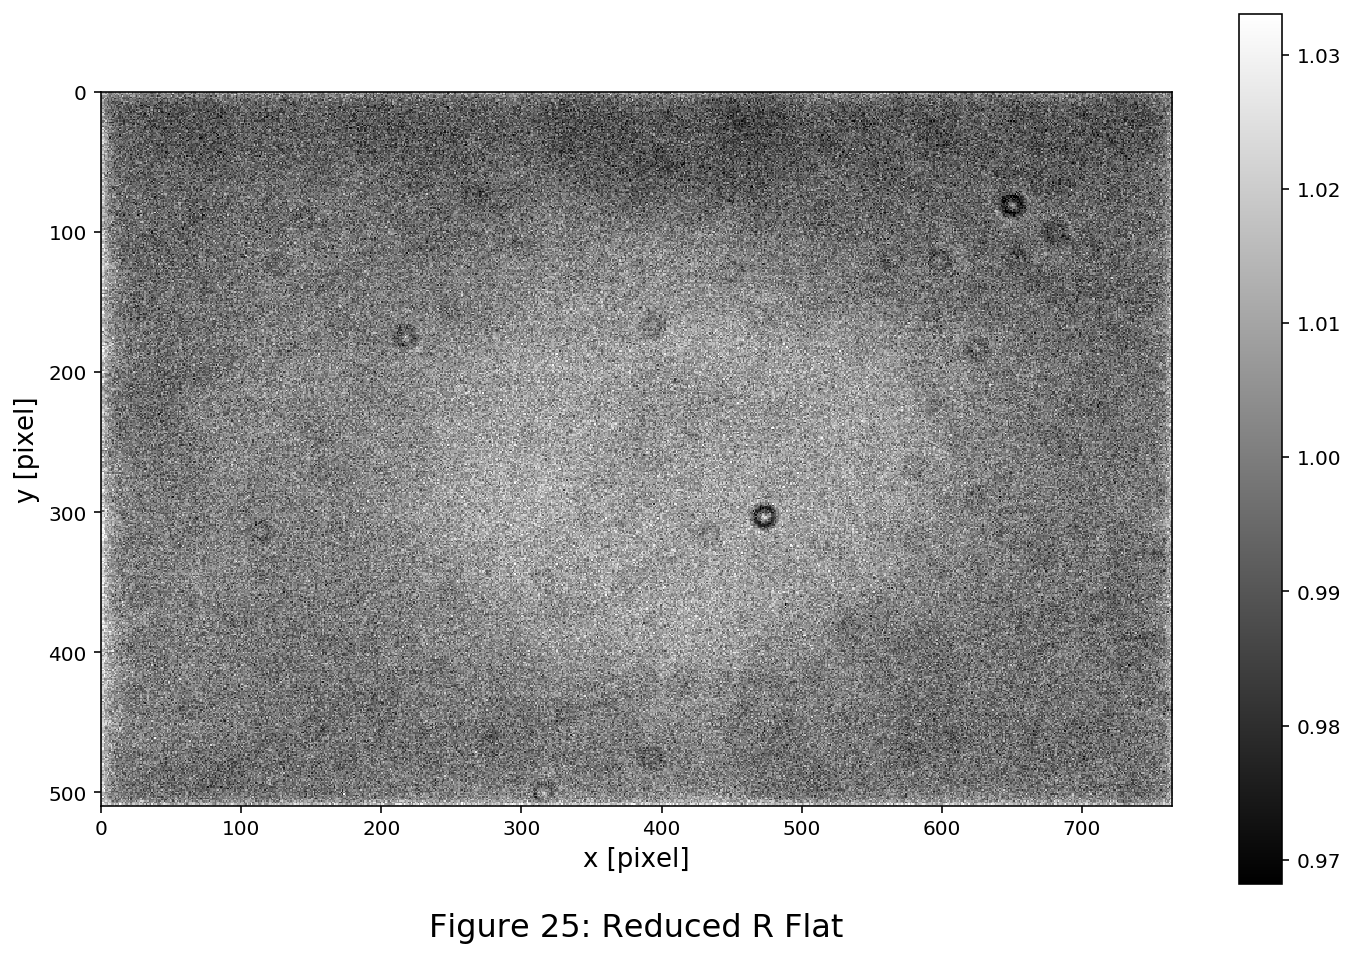

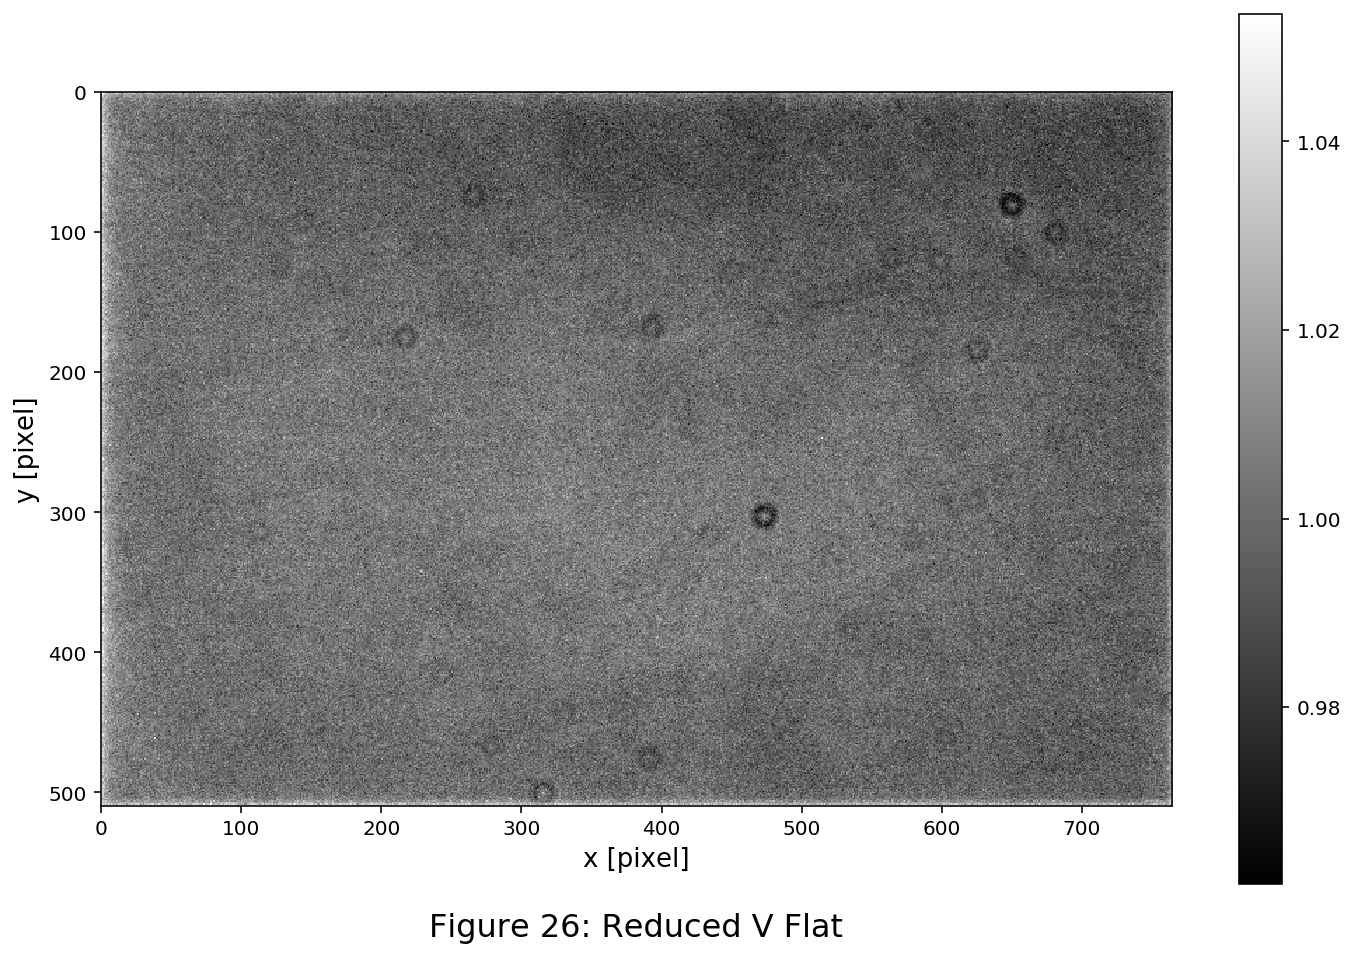

In [3]:
# Set Bias and Dark images
# -------

data_dir = './data/'
dark_dir = '../010_bias_and_dark'
bias_path = os.path.join(dark_dir, 'bias', 'reduced', 'bias_median.fits')
dark_path = os.path.join(dark_dir, 'dark', 'reduced', 'dark_median.fits')


# Load bias
bias = CCDData.read(bias_path, unit="adu")
show_image(bias, title='Figure 21: Reduced bias')
print_image_stats(bias, title="Bias")
print(f"Bias exposure time: {bias.header['EXPTIME']} s")

# Load dark
dark = CCDData.read(dark_path, unit="adu")
show_image(dark, title='Figure 22: Reduced dark')
print_image_stats(dark, title="Dark")
print(f"Dark exposure time: {dark.header['EXPTIME']} s")

# Reduce flats for all filters
# ----------

filters = ['B', "I", "R", "V"]

for i, filter in enumerate(filters):
    reduce_flats_for_filter(filter=filter,
                            fits_path=os.path.join(data_dir, 'flats'),
                            bias=bias, dark=dark, figure_number=23+i)
    
    
print("------------------")
print("We are done")

## Sanity checks

* The bias mean is 100 ADU. I can see that this was subtracted from Flat, as expected.
* The dark mean is 12 ADU. Exposure of dark is 600 sec vs 10 sec for flat. So when I subtract dark from flat, the counts changes by about 10/600 * 12 = 0.2 ADU, as expected.
* The final median combine flats have mean 1 ADU and standard eviation of 0.01 ADU, as expected.
* On flats we can see hard circles (Figugures 23-26) - these are the UFOs. Just kidding, just dust probably or something like that. Michael Brown showed us those artifacts in the lectures, so these are normal things to have in flats.
* The flat for B filter (Fig. 23) is very non-uniform, patchy. Confirm with TAs to make sure it's ok.

Overall I'm very happy with the flats!